In [556]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [557]:
df = pd.read_csv('Sunspots.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.drop(index=df[df["Monthly Mean Total Sunspot Number"] == 0].index, inplace=True)
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

In [558]:
df

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2020-09-30,0.6
2020-10-31,14.4
2020-11-30,34.0


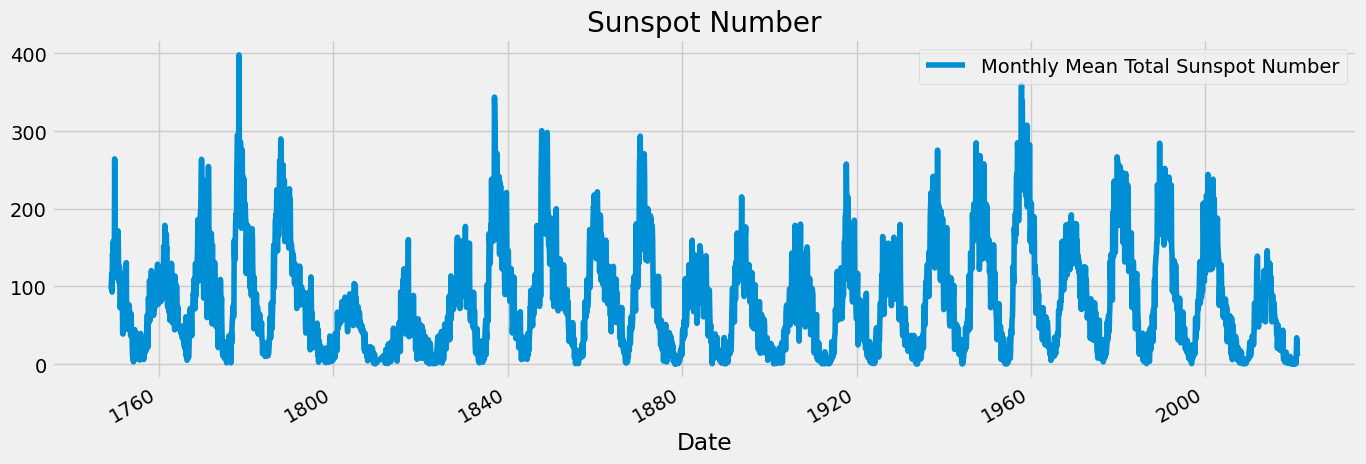

In [559]:
df.plot(style='-',
        figsize=(15, 5),
        color=color_pal[0],
        title='Sunspot Number')
plt.show()

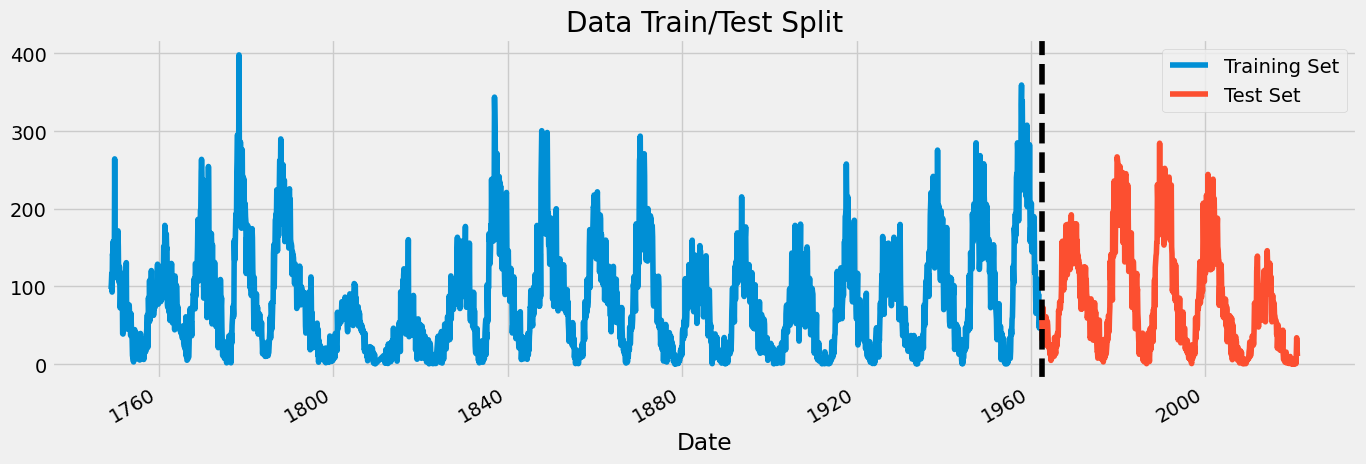

In [560]:
train = df.loc[df.index < '1962-05-31']
test = df.loc[df.index >= '1962-05-31']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('1962-05-31', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [561]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['Sunspot_lag12'] = df['Monthly Mean Total Sunspot Number'].shift(12)
    df['Sunspot_lag132'] = df['Monthly Mean Total Sunspot Number'].shift(132)
    df['Diff_12Year'] = df['Monthly Mean Total Sunspot Number'].diff(12)
    df['Diff_1Year']=df['Monthly Mean Total Sunspot Number'].diff(1)
    df['Month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df.index.month / 12)   
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['Sunspot_lag1'] = df['Monthly Mean Total Sunspot Number'].shift(1)
   
    
    return df

df = create_features(df)

In [562]:
train = create_features(train)
test = create_features(test)

FEATURES = ['Sunspot_lag132','Sunspot_lag1','Month_sin','Month_cos']
TARGET = 'Monthly Mean Total Sunspot Number'

X_train = train[FEATURES]
y_train = train[TARGET]

X_validation = validation[FEATURES]
y_validation = validation[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [563]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_validation,y_validation),(X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:105.98856	validation_1-rmse:131.52828	validation_2-rmse:106.06571
[100]	validation_0-rmse:46.77781	validation_1-rmse:57.38676	validation_2-rmse:45.04729
[200]	validation_0-rmse:30.59645	validation_1-rmse:34.35037	validation_2-rmse:27.79797
[300]	validation_0-rmse:27.33015	validation_1-rmse:28.39878	validation_2-rmse:24.46091
[400]	validation_0-rmse:26.61193	validation_1-rmse:26.88516	validation_2-rmse:23.89010


c:\Users\Monster\Desktop\Python\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:34:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[500]	validation_0-rmse:26.29316	validation_1-rmse:26.25373	validation_2-rmse:23.84781
[550]	validation_0-rmse:26.17754	validation_1-rmse:26.11706	validation_2-rmse:23.84985


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


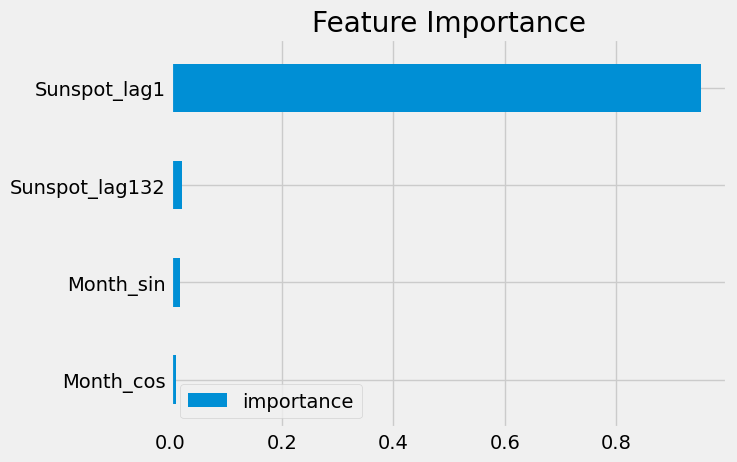

In [564]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

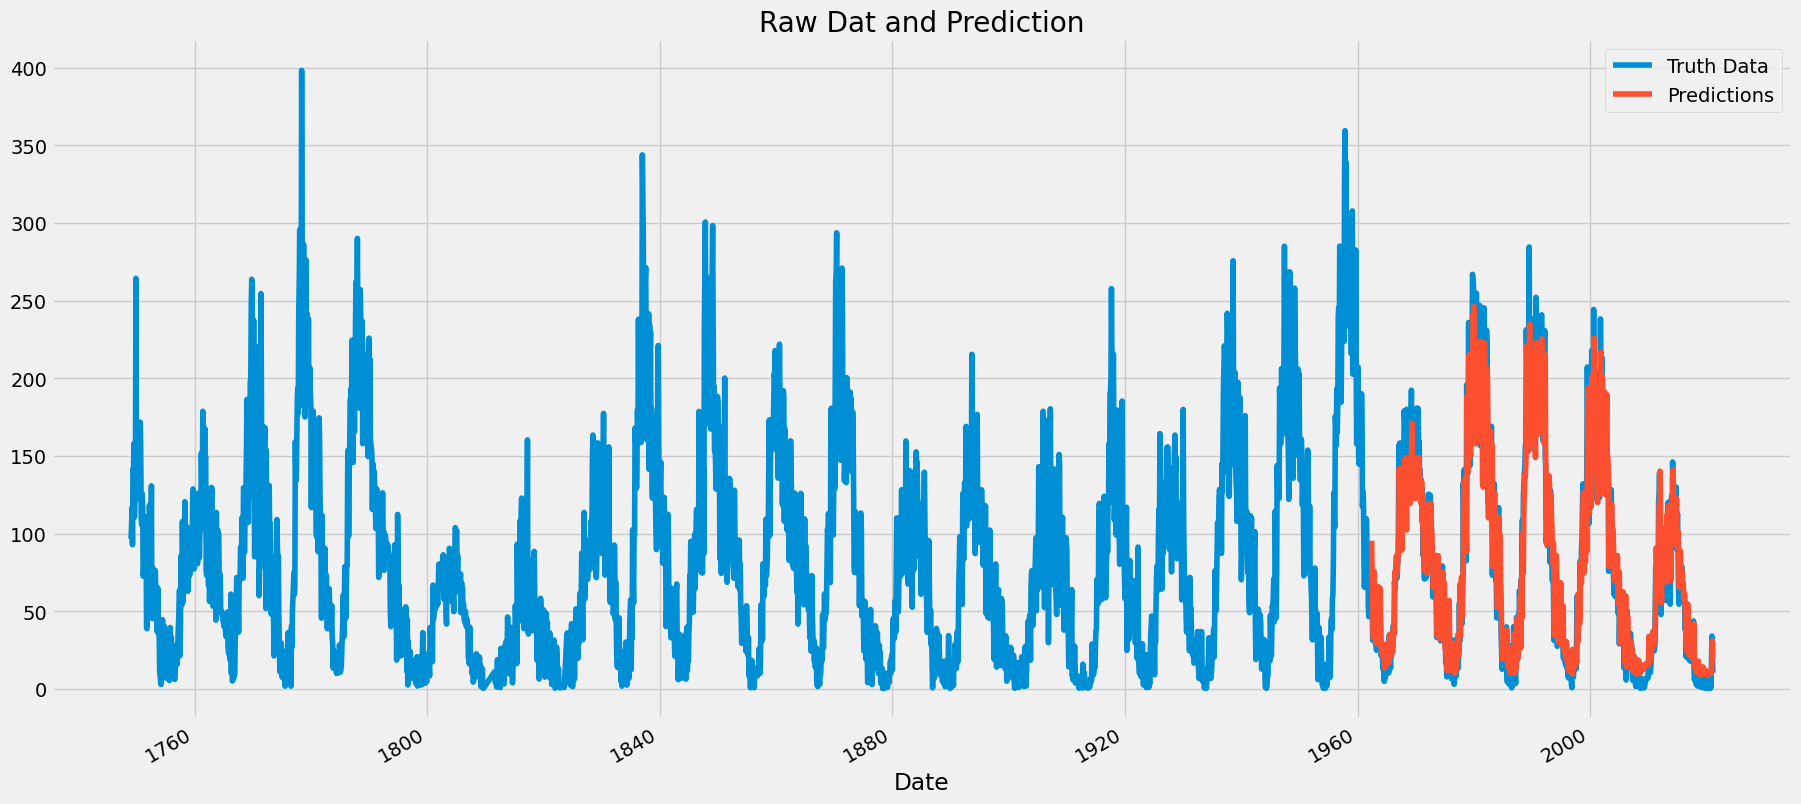

In [565]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Monthly Mean Total Sunspot Number']].plot(figsize=(20, 10))
df['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')

plt.show()

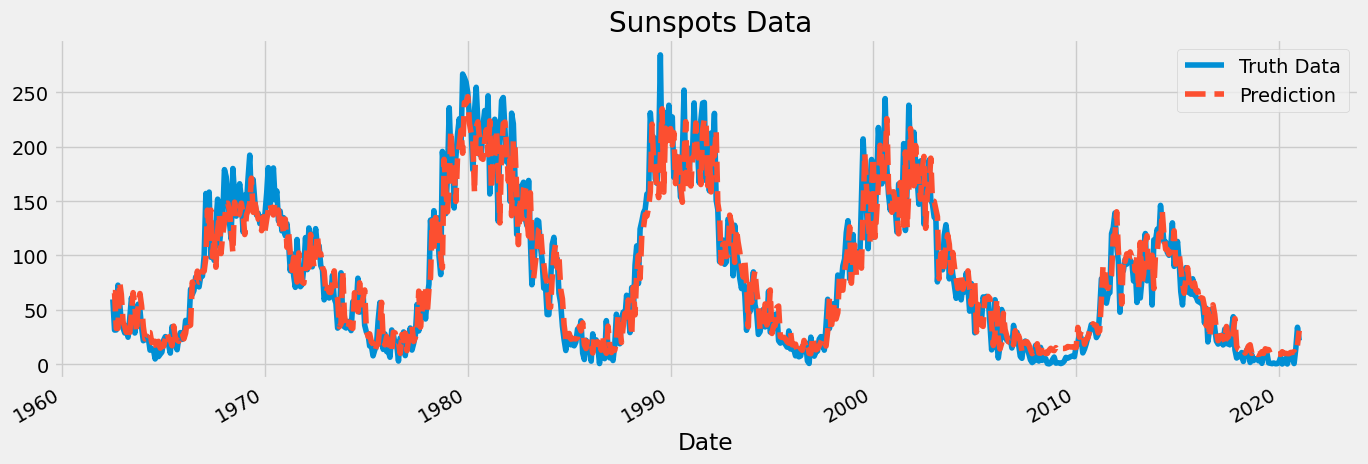

In [566]:
ax = df.loc[(df.index > '1962-05-31') & (df.index < '2021-01-31')]['Monthly Mean Total Sunspot Number'] \
    .plot(figsize=(15, 5), title=' Sunspots Data')
df.loc[(df.index > '1962-05-31') & (df.index < '2021-01-31')]['prediction'] \
    .plot(style='--')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [567]:
score = np.sqrt(mean_squared_error(test['Monthly Mean Total Sunspot Number'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 23.85


In [568]:
#test['error'] = np.abs(test[TARGET] - test['prediction'])
#test['date'] = test.index.date
#test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

In [569]:
#train = df.loc[df.index < '1962-05-31']
#validation = df.loc[(df.index >= '1962-05-31') & (df.index < '1982-05-31')]
#test = df.loc[df.index >= '1982-05-31']

In [570]:
total_size = len(df)
train_size = int(total_size * 0.7)
validation_test_size = total_size - train_size
validation_size = int(validation_test_size * 0.5) # Split the remaining 30% equally

train = df.iloc[:train_size]
validation = df.iloc[train_size:train_size + validation_size]
test = df.iloc[-validation_size:]

In [571]:
df

,Monthly Mean Total Sunspot Number,Sunspot_lag12,Sunspot_lag132,Diff_12Year,Diff_1Year,Month_sin,Month_cos,month,year,Sunspot_lag1,prediction
Date,,,,,,,,,,,
1749-01-31,96.7,NaN,NaN,NaN,NaN,5.000000e-01,8.660254e-01,1,1749,NaN,NaN
1749-02-28,104.3,NaN,NaN,NaN,7.6,8.660254e-01,5.000000e-01,2,1749,96.7,NaN
1749-03-31,116.7,NaN,NaN,NaN,12.4,1.000000e+00,6.123234e-17,3,1749,104.3,NaN
1749-04-30,92.8,NaN,NaN,NaN,-23.9,8.660254e-01,-5.000000e-01,4,1749,116.7,NaN
1749-05-31,141.7,NaN,NaN,NaN,48.9,5.000000e-01,-8.660254e-01,5,1749,92.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30,0.6,1.1,7.1,-0.5,-6.9,-1.000000e+00,-1.836970e-16,9,2020,7.5,11.525206
2020-10-31,14.4,0.4,7.7,14.0,13.8,-8.660254e-01,5.000000e-01,10,2020,0.6,9.979016
2020-11-30,34.0,0.5,6.9,33.5,19.6,-5.000000e-01,8.660254e-01,11,2020,14.4,17.824366


In [572]:
validation['prediction'] = reg.predict(X_validation)

C:\Users\Monster\AppData\Local\Temp\ipykernel_15108\45840494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['prediction'] = reg.predict(X_validation)


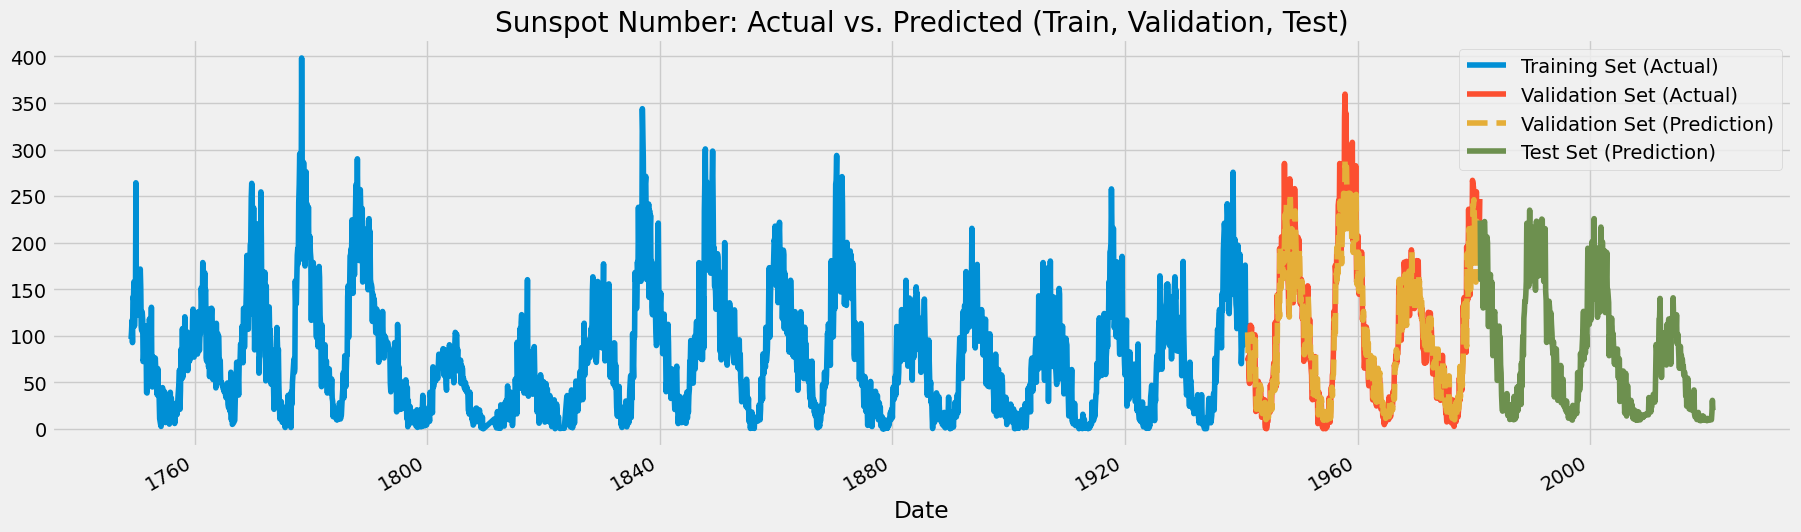

In [573]:
fig, ax = plt.subplots(figsize=(20, 6))

# Plot actual values for training set
train[TARGET].plot(ax=ax, label='Training Set (Actual)')

# Plot actual and predicted values for validation set
validation[TARGET].plot(ax=ax, label='Validation Set (Actual)')
validation['prediction'].plot(ax=ax, style='--', label='Validation Set (Prediction)')

# Plot predicted values for test set
test['prediction'].plot(ax=ax, label='Test Set (Prediction)')

ax.set_title('Sunspot Number: Actual vs. Predicted (Train, Validation, Test)')
ax.legend()
plt.show()

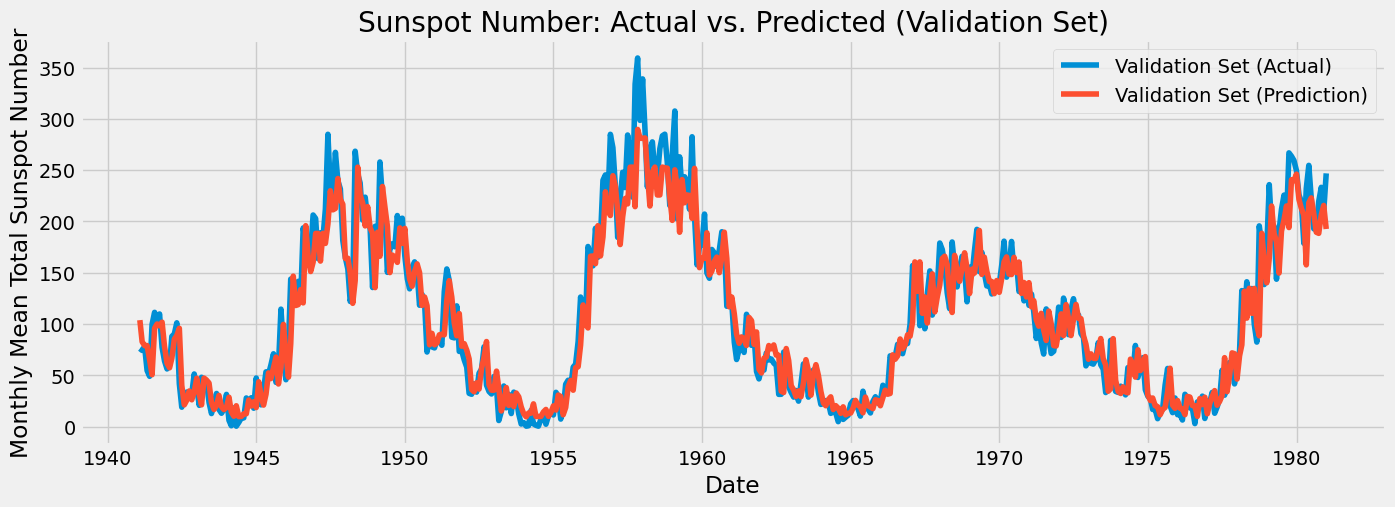

In [574]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(data=validation, x=validation.index, y=TARGET, ax=ax, label='Validation Set (Actual)')
sns.lineplot(data=validation, x=validation.index, y='prediction', ax=ax, label='Validation Set (Prediction)')


ax.lines[1].set_linestyle('-')

ax.set_title('Sunspot Number: Actual vs. Predicted (Validation Set)')
ax.legend()
plt.show()

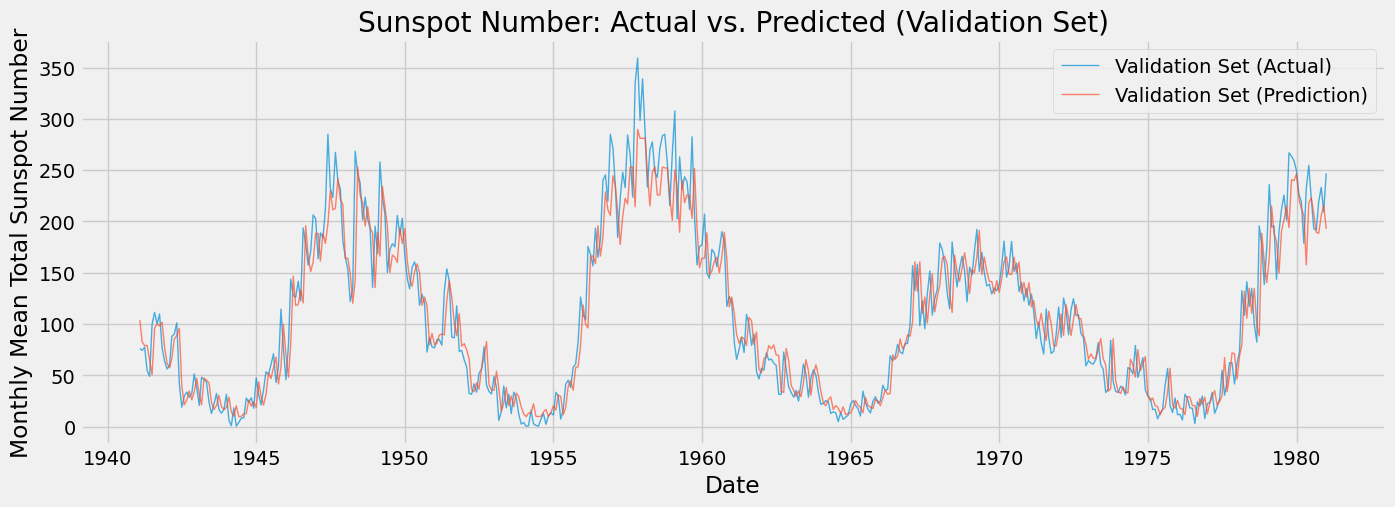

In [575]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(data=validation, x=validation.index, y=TARGET, ax=ax, 
             label='Validation Set (Actual)', linewidth=1, alpha=0.7)
sns.lineplot(data=validation, x=validation.index, y='prediction', ax=ax, 
             label='Validation Set (Prediction)', linewidth=1, alpha=0.7)

ax.lines[1].set_linestyle('-')

ax.set_title('Sunspot Number: Actual vs. Predicted (Validation Set)')
ax.legend()
plt.show()


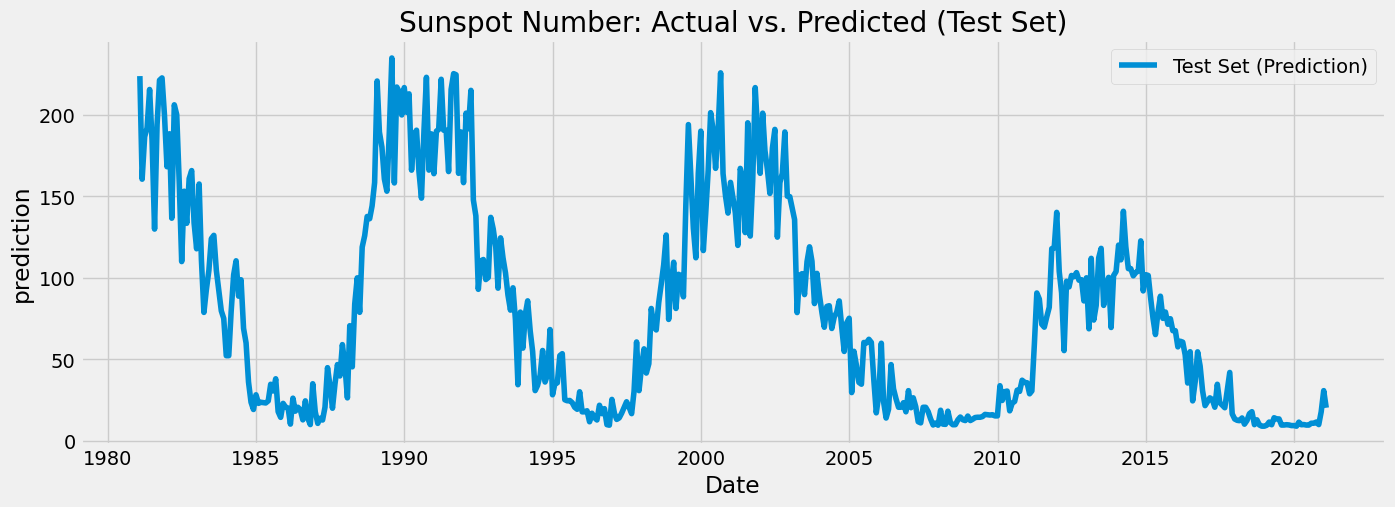

In [576]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))

#sns.lineplot(data=test, x=test.index, y=TARGET, ax=ax, label='Test Set (Actual)')
sns.lineplot(data=test, x=test.index, y='prediction', ax=ax, linestyle='-', label='Test Set (Prediction)')

ax.set_title('Sunspot Number: Actual vs. Predicted (Test Set)')
ax.legend()
plt.show()